# Median + IQR SHAP Networks

This notebook implements robust aggregation using median and interquartile range (IQR) for uncertainty quantification.

**Approach:** Use median instead of mean for aggregation (robust to outliers) and compute IQR to quantify variability/uncertainty in feature importance across patients. This provides both a robust summary and uncertainty bounds.

In [16]:
import os
import sys
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cgt_perezsechi.visualization.graph import draw
from cgt_perezsechi.manipulation.norm import normalize_psi, normalize_r

In [17]:
# Configure matplotlib for VS Code Jupyter
%matplotlib inline

In [18]:
# Load data
X = pd.read_pickle("../data/x_values.pkl")
num_patients = 500
X_shapley = X.iloc[:num_patients, :]
shap_values = np.load("../data/shap_values.npy")
shap_interaction_values = np.load("../data/shap_interaction_values.npy")

## Build Median-Based SHAP Values (psi_1)

In [19]:
shap_values_clean = np.nan_to_num(shap_values)
n_features = shap_values_clean.shape[1]

# Calculate median SHAP values across patients
median_shap = np.median(shap_values_clean, axis=0)

# Calculate IQR (25th to 75th percentile)
q25_shap = np.percentile(shap_values_clean, 25, axis=0)
q75_shap = np.percentile(shap_values_clean, 75, axis=0)
iqr_shap = q75_shap - q25_shap

# Calculate absolute median for normalization
sum_abs_median_shap = np.sum(np.abs(median_shap))

# Build psi matrices
psi_1_median = pd.DataFrame()
psi_1_median['value'] = median_shap / sum_abs_median_shap
psi_1_median['iqr'] = iqr_shap / sum_abs_median_shap
psi_1_median['q25'] = q25_shap / sum_abs_median_shap
psi_1_median['q75'] = q75_shap / sum_abs_median_shap
psi_1_median['cv'] = iqr_shap / (np.abs(median_shap) + 1e-10)  # Coefficient of variation
psi_1_median.set_index(X_shapley.columns, inplace=True)

print("Median-based node weights (psi) with uncertainty:")
print(psi_1_median.head(10))

Median-based node weights (psi) with uncertainty:
                                        value       iqr       q25       q75  \
sex_isFemale                        -0.116080  0.287531 -0.144984  0.142547   
age                                 -0.569922  1.697343 -1.063635  0.633708   
physical_activity                   -0.029620  0.082750 -0.036400  0.046349   
serum_albumin                       -0.025356  0.069424 -0.031790  0.037634   
alkaline_phosphatase                 0.002254  0.005989  0.000036  0.006025   
alkaline_phosphatase_isUnacceptable -0.000009  0.000505 -0.000021  0.000484   
alkaline_phosphatase_isTestnotdone  -0.000028  0.000070 -0.000087 -0.000016   
SGOT                                -0.003781  0.003800 -0.005064 -0.001263   
SGOT_isUnacceptable                 -0.000242  0.000092 -0.000290 -0.000198   
SGOT_isTestnotdone                  -0.000033  0.000013 -0.000037 -0.000025   

                                            cv  
sex_isFemale                   

## Build Median-Based Interaction Values (r_1)

In [20]:
# Remove diagonal
n_variables = shap_interaction_values.shape[1]
filtered_shap_interaction_values = np.nan_to_num(shap_interaction_values.copy())
idx_patients = np.repeat(np.arange(num_patients), n_variables)
idx_variables = np.tile(np.arange(n_variables), num_patients)
filtered_shap_interaction_values[idx_patients, idx_variables, idx_variables] = 0

# Calculate median interaction values across patients
median_interaction = np.median(filtered_shap_interaction_values, axis=0)

# Calculate IQR for interactions
q25_interaction = np.percentile(filtered_shap_interaction_values, 25, axis=0)
q75_interaction = np.percentile(filtered_shap_interaction_values, 75, axis=0)
iqr_interaction = q75_interaction - q25_interaction

# Normalize
sum_abs_median_interaction = np.sum(np.abs(median_interaction))

# Build r_1 with uncertainty
r_1_median = pd.DataFrame(median_interaction / sum_abs_median_interaction)
r_1_median.rename(columns=dict(list(zip(r_1_median.columns, X_shapley.columns))), inplace=True)
r_1_median.set_index(X_shapley.columns, inplace=True)

# Store IQR separately
r_1_iqr = pd.DataFrame(iqr_interaction / sum_abs_median_interaction)
r_1_iqr.rename(columns=dict(list(zip(r_1_iqr.columns, X_shapley.columns))), inplace=True)
r_1_iqr.set_index(X_shapley.columns, inplace=True)

print(f"\nMedian-based edge weights (r) computed")
print(f"Mean IQR for interactions: {iqr_interaction.mean():.6f}")


Median-based edge weights (r) computed
Mean IQR for interactions: 0.000136


## Normalize Matrices

In [21]:
# Create psi_1 with just the value column for normalization
psi_1 = psi_1_median[['value']].copy()
psi_2 = normalize_psi(psi_1)
r_2 = normalize_r(r_1_median)

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_edge_width = r.applymap(lambda x: abs(x)).max().max()
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(lambda x: x / max_edge_width)


## Visualization

In [22]:
shap_cmap = shap.plots.colors.red_blue
positive_color = shap_cmap(0.0)[:3]
negative_color = shap_cmap(1.0)[:3]

positive_alpha = 0.01
negative_alpha = 0.01
positive_beta = 0
negative_beta = 0

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\visualization\graph.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(filter_edge)
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\visualization\graph.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  adjacency = r.copy().applymap(lambda x: 1 if x != 0 else 0)


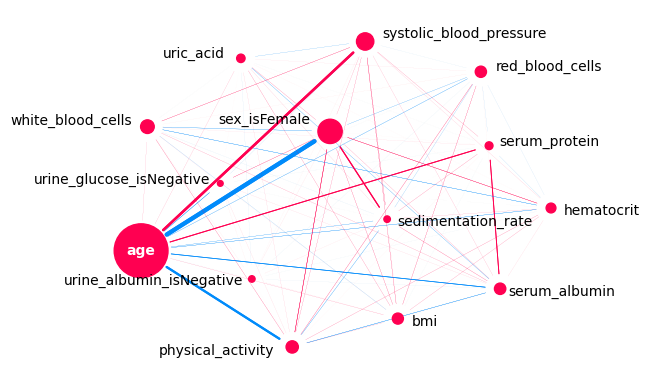

In [23]:
draw(
    psi=psi_2,
    r=r_2,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
)

## Top Features with Uncertainty Bounds

In [24]:
# Show top features with their uncertainty
top_n = 15
top_features = psi_1_median['value'].abs().nlargest(top_n)

print(f"\nTop {top_n} Features with Uncertainty (Median ± IQR):")
print("="*80)
for idx, feature in enumerate(top_features.index, 1):
    median_val = psi_1_median.loc[feature, 'value']
    iqr_val = psi_1_median.loc[feature, 'iqr']
    cv_val = psi_1_median.loc[feature, 'cv']
    q25_val = psi_1_median.loc[feature, 'q25']
    q75_val = psi_1_median.loc[feature, 'q75']
    
    print(f"{idx:2d}. {feature}")
    print(f"    Median: {median_val:8.5f}  |  IQR: {iqr_val:8.5f}  |  CV: {cv_val:6.2f}")
    print(f"    Range: [{q25_val:8.5f}, {q75_val:8.5f}]")
    print()


Top 15 Features with Uncertainty (Median ± IQR):
 1. age
    Median: -0.56992  |  IQR:  1.69734  |  CV:   2.98
    Range: [-1.06363,  0.63371]

 2. sex_isFemale
    Median: -0.11608  |  IQR:  0.28753  |  CV:   2.48
    Range: [-0.14498,  0.14255]

 3. systolic_blood_pressure
    Median: -0.05913  |  IQR:  0.17114  |  CV:   2.89
    Range: [-0.13929,  0.03186]

 4. white_blood_cells
    Median: -0.03655  |  IQR:  0.09774  |  CV:   2.67
    Range: [-0.05927,  0.03847]

 5. physical_activity
    Median: -0.02962  |  IQR:  0.08275  |  CV:   2.79
    Range: [-0.03640,  0.04635]

 6. serum_albumin
    Median: -0.02536  |  IQR:  0.06942  |  CV:   2.74
    Range: [-0.03179,  0.03763]

 7. red_blood_cells
    Median: -0.02478  |  IQR:  0.00484  |  CV:   0.20
    Range: [-0.02685, -0.02201]

 8. bmi
    Median: -0.02409  |  IQR:  0.06170  |  CV:   2.56
    Range: [-0.03461,  0.02710]

 9. hematocrit
    Median: -0.01892  |  IQR:  0.04435  |  CV:   2.34
    Range: [-0.02669,  0.01765]

10. uric_

## Visualization: Feature Importance with Error Bars

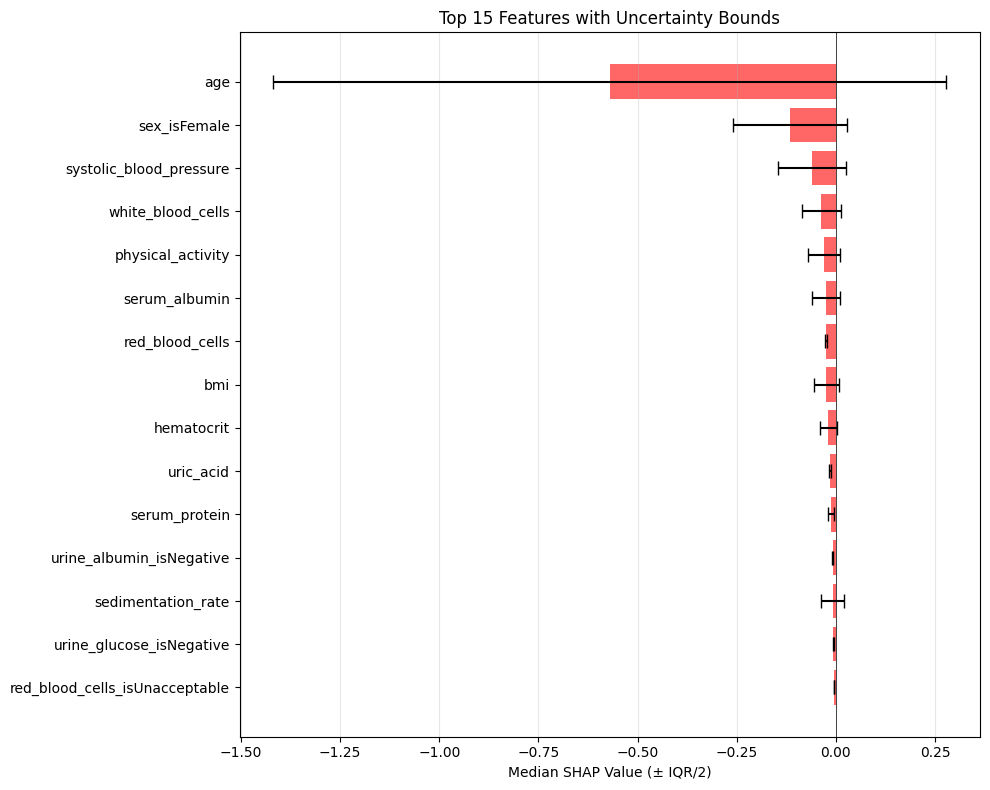

In [25]:
# Plot top features with error bars (IQR)
top_features_data = psi_1_median.loc[top_features.index].copy()
top_features_data = top_features_data.sort_values('value', key=abs, ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))

y_pos = np.arange(len(top_features_data))
colors = ['red' if x < 0 else 'blue' for x in top_features_data['value']]

ax.barh(y_pos, top_features_data['value'], xerr=top_features_data['iqr']/2, 
        color=colors, alpha=0.6, capsize=5)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features_data.index)
ax.set_xlabel('Median SHAP Value (± IQR/2)')
ax.set_title(f'Top {top_n} Features with Uncertainty Bounds')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Uncertainty Analysis: High vs Low Variability Features

In [26]:
# Identify features with high vs low uncertainty
print("\nFeatures with HIGHEST Uncertainty (large IQR):")
high_uncertainty = psi_1_median.nlargest(10, 'iqr')[['value', 'iqr', 'cv']]
print(high_uncertainty)

print("\n" + "="*80)
print("\nFeatures with LOWEST Uncertainty (small IQR, high importance):")
# Filter to important features first (abs value > median)
important_features = psi_1_median[psi_1_median['value'].abs() > psi_1_median['value'].abs().median()]
low_uncertainty = important_features.nsmallest(10, 'iqr')[['value', 'iqr', 'cv']]
print(low_uncertainty)


Features with HIGHEST Uncertainty (large IQR):
                            value       iqr        cv
age                     -0.569922  1.697343  2.978204
sex_isFemale            -0.116080  0.287531  2.477002
systolic_blood_pressure -0.059131  0.171142  2.894311
white_blood_cells       -0.036555  0.097738  2.673762
physical_activity       -0.029620  0.082750  2.793687
serum_albumin           -0.025356  0.069424  2.737945
bmi                     -0.024093  0.061704  2.561089
sedimentation_rate      -0.008278  0.060079  7.258066
hematocrit              -0.018916  0.044346  2.344326
cholesterol             -0.004941  0.039505  7.996211


Features with LOWEST Uncertainty (small IQR, high importance):
                                            value       iqr        cv
urine_albumin_is>=30                    -0.000321  0.000059  0.184764
urine_albumin_is>=300                   -0.000602  0.000100  0.166492
calcium_isUnacceptable                  -0.000482  0.000134  0.278209
urine_glucose

## Scatter Plot: Importance vs Uncertainty

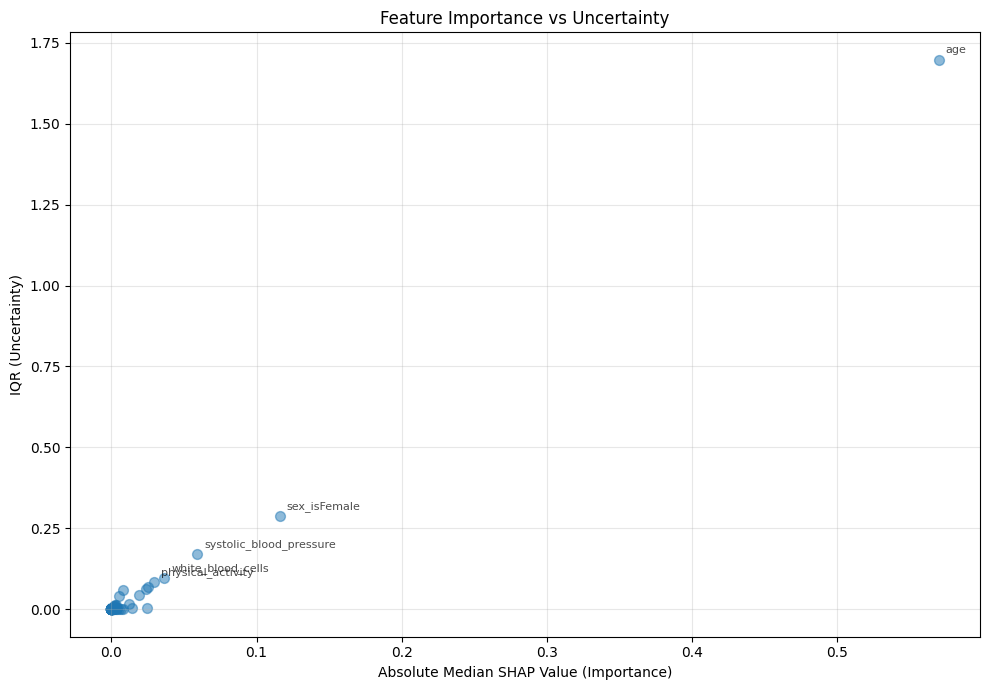

In [27]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(psi_1_median['value'].abs(), psi_1_median['iqr'], alpha=0.5, s=50)
ax.set_xlabel('Absolute Median SHAP Value (Importance)')
ax.set_ylabel('IQR (Uncertainty)')
ax.set_title('Feature Importance vs Uncertainty')
ax.grid(True, alpha=0.3)

# Annotate top features
for feature in top_features.head(5).index:
    x = psi_1_median.loc[feature, 'value']
    y = psi_1_median.loc[feature, 'iqr']
    ax.annotate(feature, (abs(x), y), fontsize=8, alpha=0.7,
               xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

## Comparison: Mean vs Median Aggregation

In [28]:
# Compare mean-based aggregation (original method) with median
mean_shap = np.mean(shap_values_clean, axis=0)
sum_abs_mean_shap = np.sum(np.abs(mean_shap))
mean_normalized = mean_shap / sum_abs_mean_shap

comparison_df = pd.DataFrame({
    'mean': mean_normalized,
    'median': psi_1_median['value'],
    'difference': mean_normalized - psi_1_median['value'].values
}, index=X_shapley.columns)

comparison_df['abs_difference'] = comparison_df['difference'].abs()

print("\nFeatures with LARGEST differences between Mean and Median:")
print("(Indicates presence of outliers)\n")
print(comparison_df.nlargest(15, 'abs_difference')[['mean', 'median', 'difference']])


Features with LARGEST differences between Mean and Median:
(Indicates presence of outliers)

                        mean    median  difference
sex_isFemale       -0.044630 -0.116080    0.071451
white_blood_cells   0.019159 -0.036555    0.055714
sedimentation_rate  0.045391 -0.008278    0.053668
age                -0.617126 -0.569922   -0.047205
bmi                 0.022026 -0.024093    0.046119
serum_albumin       0.009620 -0.025356    0.034976
cholesterol         0.024861 -0.004941    0.029802
serum_protein       0.016092 -0.012002    0.028094
physical_activity  -0.004908 -0.029620    0.024713
red_blood_cells    -0.042073 -0.024782   -0.017291
SGOT                0.012001 -0.003781    0.015782
hemoglobin          0.012640 -0.002367    0.015006
hematocrit         -0.005651 -0.018916    0.013266
uric_acid          -0.001653 -0.013901    0.012248
pulse_pressure      0.006949 -0.003092    0.010041


## Distribution Analysis for Top Features

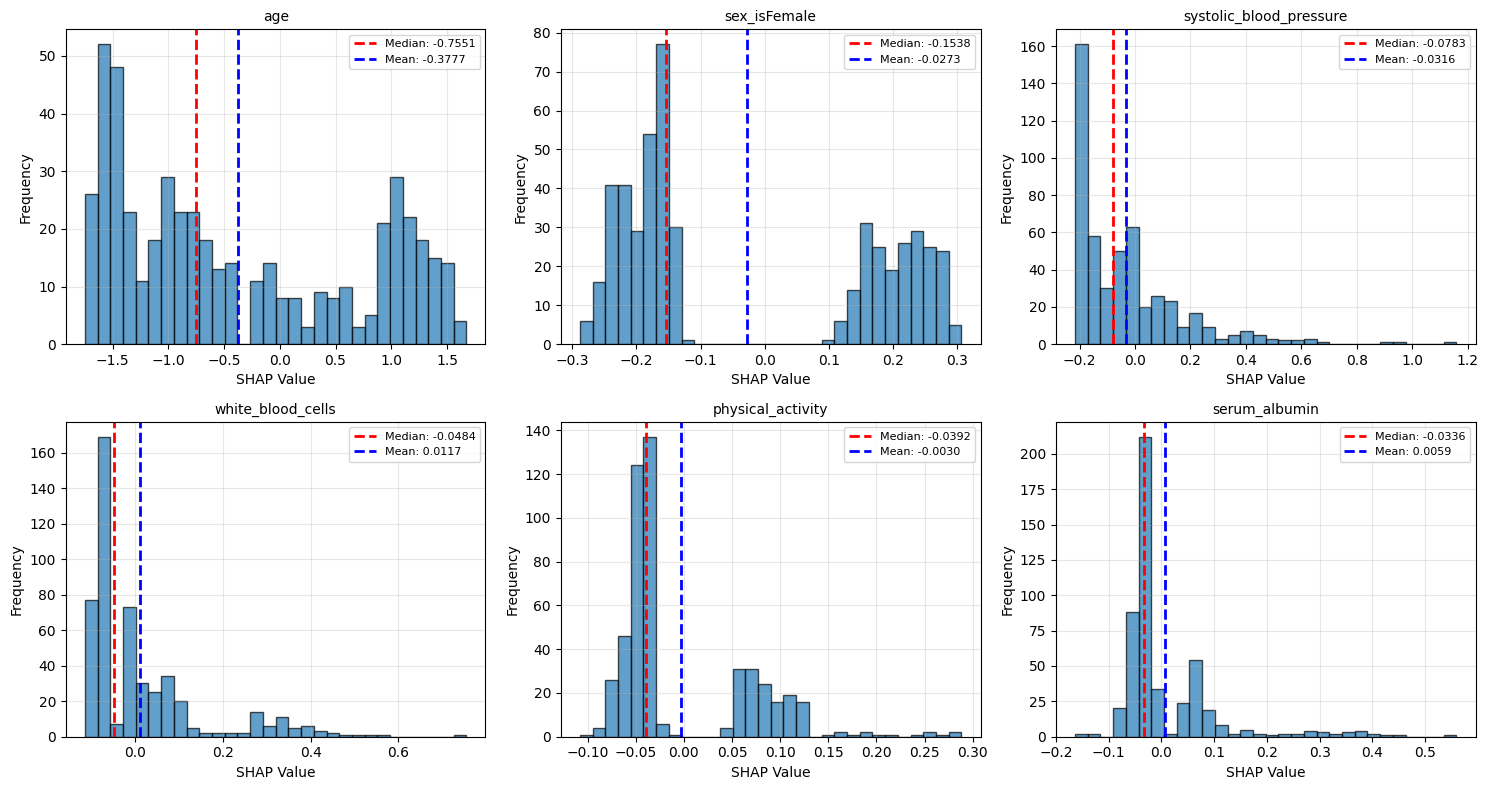

In [29]:
# Show distribution of SHAP values for top 6 features
top_6_features = top_features.head(6).index

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, feature in enumerate(top_6_features):
    feature_idx = list(X_shapley.columns).index(feature)
    feature_shap_values = shap_values_clean[:, feature_idx]
    
    ax = axes[idx]
    ax.hist(feature_shap_values, bins=30, edgecolor='black', alpha=0.7)
    
    # Add median and mean lines
    median_val = np.median(feature_shap_values)
    mean_val = np.mean(feature_shap_values)
    
    ax.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val:.4f}')
    ax.axvline(mean_val, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.4f}')
    
    ax.set_xlabel('SHAP Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{feature}', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary Statistics

In [30]:
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nMedian absolute SHAP value: {psi_1_median['value'].abs().median():.6f}")
print(f"Mean absolute SHAP value: {psi_1_median['value'].abs().mean():.6f}")
print(f"\nMedian IQR: {psi_1_median['iqr'].median():.6f}")
print(f"Mean IQR: {psi_1_median['iqr'].mean():.6f}")
print(f"\nMedian Coefficient of Variation: {psi_1_median['cv'].median():.2f}")
print(f"Mean Coefficient of Variation: {psi_1_median['cv'].mean():.2f}")

# Features with consistent effects (low CV)
consistent_features = psi_1_median[psi_1_median['cv'] < 1.0]
print(f"\nFeatures with CV < 1.0 (relatively consistent): {len(consistent_features)} / {len(psi_1_median)}")


SUMMARY STATISTICS

Median absolute SHAP value: 0.000314
Mean absolute SHAP value: 0.012500

Median IQR: 0.000160
Mean IQR: 0.033924

Median Coefficient of Variation: 0.62
Mean Coefficient of Variation: 5.15

Features with CV < 1.0 (relatively consistent): 46 / 80
